In [1]:
import scanpy as sc
import numpy as np
import torch

import os,sys
pwd = '/home/lijiahao/workbench/SAVE/'
sys.path.append(pwd)
os.chdir(pwd)

from model.save_model import SAVE
from model.utils.process_h5ad import batch_scale, preprocessing_rna

In [2]:
# download the data via link: https://figshare.com/ndownloader/files/24539828

In [3]:
adata = sc.read_h5ad('human_pancreas_norm_complexBatch.h5ad')
adata.obs["batch"] = adata.obs["tech"]
adata.obs["cell_type"] = adata.obs["celltype"]

In [4]:
adata = preprocessing_rna(adata, is_batch_scale=True)

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
batch_scale: 100%|████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


In [5]:
device = torch.device('cuda:0')
seed = 1202
kwargs = {
    "device": device,
    "seed": seed,
    "is_data_scaled": True,
}
import yaml

with open(pwd + "/model_setting.yml", "r") as f:
    setting = yaml.safe_load(f)

kwargs.update(setting["SAVE-B"]["train"])
kwargs.update(setting["SAVE-B"]["model"])

In [6]:
from model.save_model import SAVE

save_model = SAVE(
    adata=adata.copy(),
    is_initialized=True,
    condition_cols=['batch'],
    **kwargs,
    )


total col comb is: 1
initialze model weight with seed 1202


In [23]:
save_model.train(**kwargs)
save_model.save_ckpt('ckpt/human_pancreas_norm_complexBatch.pt')

cond encoding max: 8 min:0
total iter: 3200


100%|██████| 200/200 [08:25<00:00,  2.53s/it, recon_loss=411.257,kl_loss=10.966]

save ckpt to ckpt/human_pancreas_norm_complexBatch2.pt!


In [7]:
save_model.load_ckpt('./ckpt/SAVE_1019_cov_scib_opt.pt')

successfully load ./ckpt/SAVE_1019_cov_scib_opt.pt!


In [8]:
from model.utils.recon_utils import get_batch_corres_idx, get_one_batch
batch_dict = get_batch_corres_idx(adata.copy())

In [9]:
batch_list = list(batch_dict.keys())
target_batch = batch_list[0]

In [10]:
msk = adata.obs['batch'] == target_batch
input_data = adata[~msk].copy()
target_data = adata[msk].copy()

In [11]:
trans_data = save_model.transfer_cond(input_adata=input_data, target_cond={'batch': target_batch})

100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


In [12]:
trans_data.obs['cell_type'] = list(input_data.obs['cell_type'])
trans_data.obs['cell_type'] = trans_data.obs['cell_type'].astype('category')

In [13]:
integrated_data = sc.concat([target_data, trans_data])

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


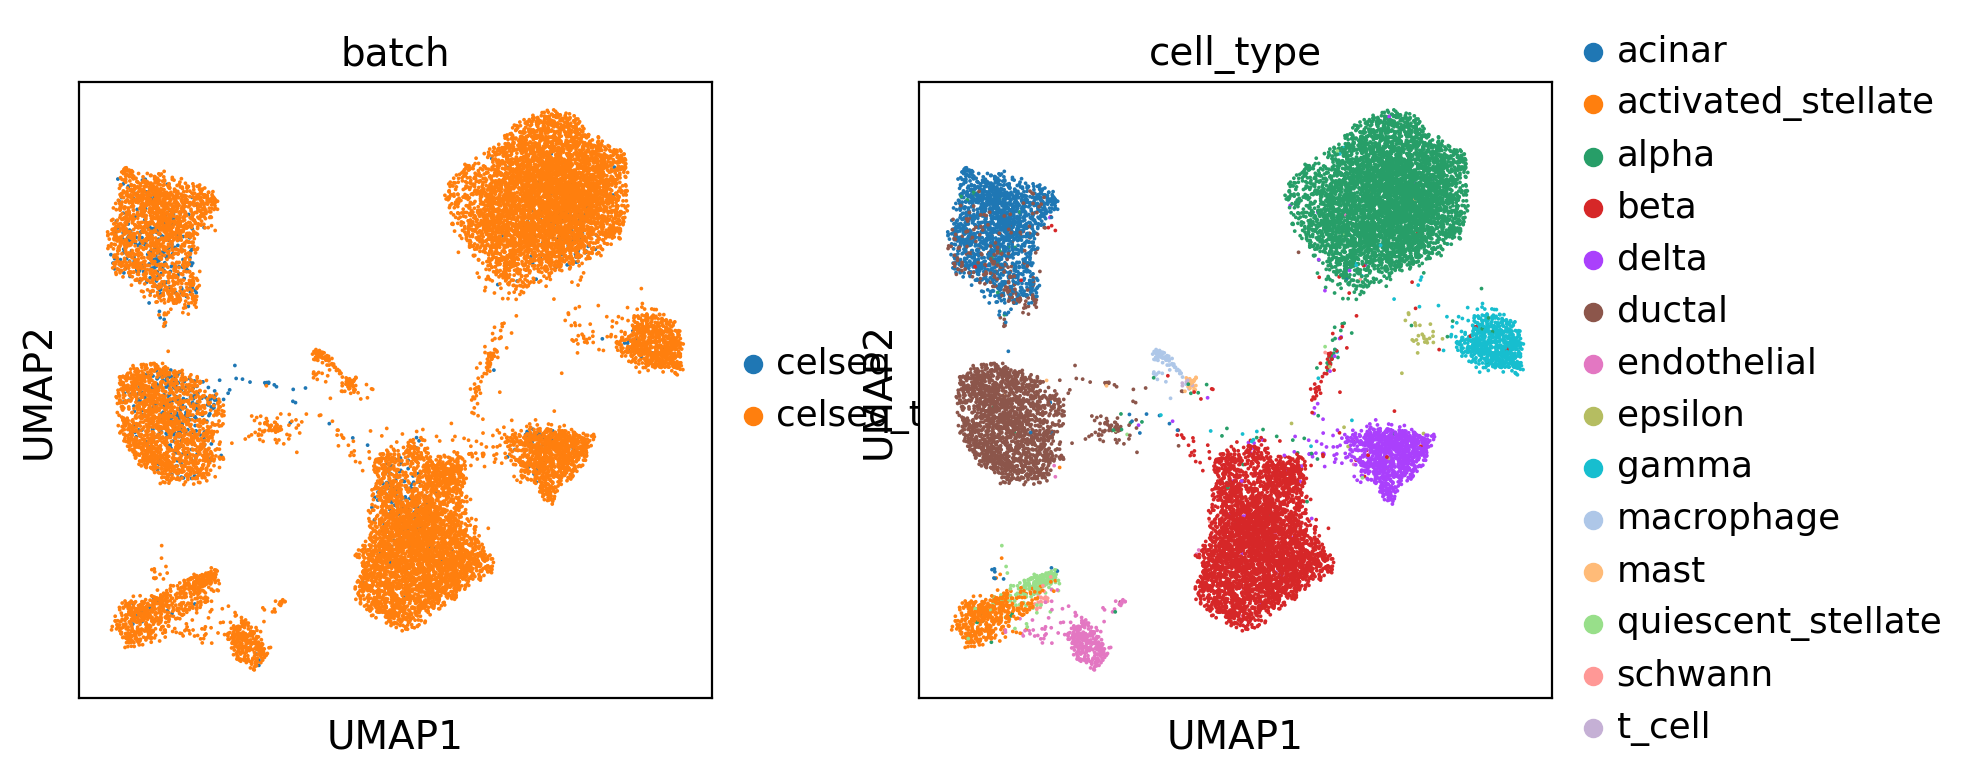

: 

In [14]:
sc.set_figure_params(dpi=100)
sc.pp.pca(integrated_data)
sc.pp.neighbors(integrated_data)
sc.tl.umap(integrated_data)
sc.pl.umap(integrated_data, color=['batch', 'cell_type'])